In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
erai_forced = pd.DataFrame()
for state in ["sa","vic","tas","nsw"]:

    #Read the dataframe for a given state (10-min gusts at station locations)
    print(state)
    df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_erai_historical_"+state+".csv")

    #Convert time to a datetime object, drop out-of-period times
    df["time"] = pd.to_datetime(df["time"])
    df = df[np.in1d(df.time.dt.month, [12,1,2])]
    df = df[(df.time >= "1990-12-1") & (df.time <= "2005-12-31")]

    #Drop unused columns
    df = df.drop(columns = ["Unnamed: 0","lat","lon","forecast_period","forecast_reference_time","height"])

    #Resample to daily max
    df_dmax = df.groupby([df.stn_id,df.time.dt.date]).max().drop(columns=["time"])
    erai_forced = pd.concat([erai_forced, df_dmax],axis=0)

sa
vic
tas
nsw


In [3]:
access_forced = pd.DataFrame()
for state in ["sa","vic","tas","nsw"]:

    #Read the dataframe for a given state (10-min gusts at station locations)
    print(state)
    df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_ACCESS1-0_historical_"+state+".csv")

    #Convert time to a datetime object, drop out-of-period times
    df["time"] = pd.to_datetime(df["time"])
    df = df[np.in1d(df.time.dt.month, [12,1,2])]
    df = df[(df.time >= "1990-12-1") & (df.time <= "2005-12-31")]

    #Drop unused columns
    df = df.drop(columns = ["Unnamed: 0","lat","lon","forecast_period","forecast_reference_time","height","realization"])

    #Resample to daily max
    df_dmax = df.groupby([df.stn_id,df.time.dt.date]).max().drop(columns=["time"])
    access_forced = pd.concat([access_forced, df_dmax],axis=0)

sa
vic
tas
nsw


In [4]:
print(erai_forced.shape,access_forced.shape)

(403589, 1) (407690, 1)


In [5]:
#Resample to domain max
access_forced = access_forced.reset_index().groupby("time").max().drop(columns=["stn_id"])
erai_forced = erai_forced.reset_index().groupby("time").max().drop(columns=["stn_id"])

In [10]:
#Get the erai forced data using the same code as used for the 1990-2005 period
erai_forced_2015 = pd.DataFrame()
for state in ["sa","vic","tas","nsw"]:

    #Read the dataframe for a given state (10-min gusts at station locations)
    print(state)
    df = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/barpac_m_erai_historical_"+state+"_2005_2015.csv")

    #Convert time to a datetime object, drop out-of-period times
    df["time"] = pd.to_datetime(df["time"])
    df = df[np.in1d(df.time.dt.month, [12,1,2])]
    df = df[(df.time >= "2005-12-1") & (df.time <= "2015-12-31")]

    #Drop unused columns
    df = df.drop(columns = ["Unnamed: 0","lat","lon","forecast_period","forecast_reference_time","height"])

    #Resample to daily max
    df_dmax = df.groupby([df.stn_id,df.time.dt.date]).max().drop(columns=["time"])
    erai_forced_2015 = pd.concat([erai_forced_2015, df_dmax],axis=0)
    
erai_forced_2015 = erai_forced_2015.reset_index().groupby("time").max().drop(columns=["stn_id"])    

sa
vic
tas
nsw


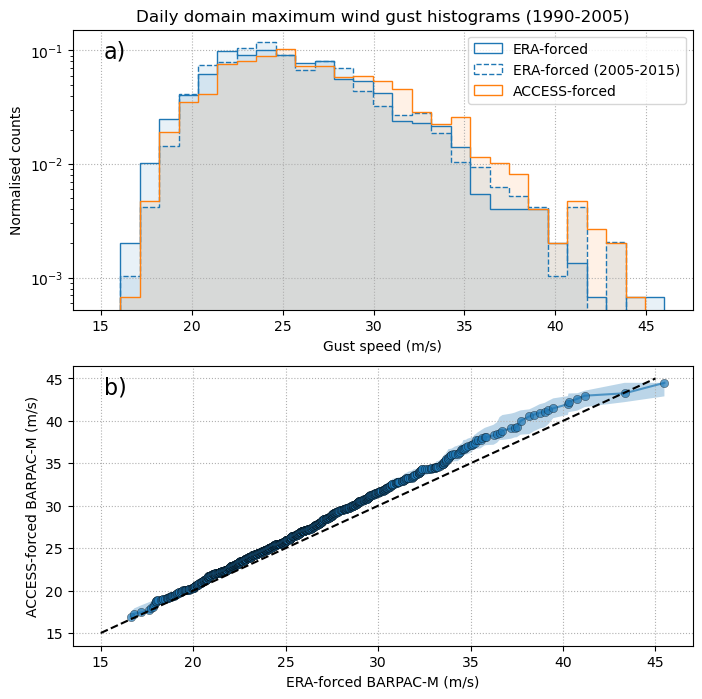

In [74]:
plt.figure(figsize=[8,8])

plt.subplot(2,1,1)

values_erai = erai_forced["max_wndgust10m"].values
values_erai_orig = erai_forced_2015.max_wndgust10m.values
values_access = access_forced["max_wndgust10m"].values


cols = ["tab:blue","tab:blue","tab:orange"]
bins=np.linspace(15,46,30)
density=True
log=True

plt.hist(values_erai,log=log,bins=bins,histtype="stepfilled",alpha=0.1,color=cols[0],density=density);
plt.hist(values_erai_orig,log=log,bins=bins,histtype="stepfilled",alpha=0.1,color=cols[1],density=density);
plt.hist(values_access,log=log,bins=bins,histtype="stepfilled",alpha=0.1,color=cols[2],density=density);

plt.hist(values_erai,log=log,bins=bins,histtype="step",color=cols[0],density=density,ls="-",label="ERA-forced");
plt.hist(values_erai_orig,log=log,bins=bins,histtype="step",color=cols[1],density=density,ls="--",label="ERA-forced (2005-2015)");
plt.hist(values_access,log=log,bins=bins,histtype="step",color=cols[2],density=density,ls="-",label="ACCESS-forced");

plt.legend()

plt.gca().grid(ls=":")
plt.xlabel("Gust speed (m/s)")
plt.title("Daily domain maximum wind gust histograms (1990-2005)")
plt.ylabel("Normalised counts")
plt.text(0.05,0.9,"a)",size=16,transform=plt.gca().transAxes)

#Use pyplot to plot a rank-size wind gust distribution

plt.subplot(2,1,2)
p=1000
plt.plot(np.percentile(values_erai,np.linspace(0,100,p)),np.percentile(values_access,np.linspace(0,100,p)),ls="-",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:blue")

access_resamp = [np.percentile(values_access[np.random.randint(0,len(values_access),len(values_access))],np.linspace(0,100,p)) for N in np.arange(1000)]
plt.fill_between(np.percentile(values_erai,np.linspace(0,100,p)), np.percentile(access_resamp,2.5,axis=0), np.percentile(access_resamp,97.5,axis=0),alpha=0.3)


plt.plot([15,45],[15,45],color="k",ls="--")
plt.gca().grid(ls=":")
plt.ylabel("ACCESS-forced BARPAC-M (m/s)")
plt.xlabel("ERA-forced BARPAC-M (m/s)")
plt.text(0.05,0.9,"b)",size=16,transform=plt.gca().transAxes)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/hist_access.jpeg",dpi=400,bbox_inches="tight")

In [6]:
temp = pd.concat([access_forced,erai_forced],axis=1)
temp[temp.isnull().max(axis=1).values]

,max_wndgust10m,max_wndgust10m
time,,
2004-12-01,22.077148,NaN
2004-12-02,22.404297,NaN
2005-12-29,NaN,30.380860
2005-12-30,NaN,30.367188
2005-12-31,NaN,19.052734


In [52]:
print(
    "ERAI-forced (1990-2005): \n",erai_forced.quantile([0,0.25,0.5,0.75,1]),"\n",
    "\nERAI-forced (2005-2015): \n",erai_forced_2015.quantile([0,0.25,0.5,0.75,1]),"\n",
    "\nACCESS-forced (1990-2005): \n",access_forced.quantile([0,0.25,0.5,0.75,1]),"\n"
)

ERAI-forced (1990-2005): 
       max_wndgust10m
0.00       16.620117
0.25       22.427734
0.50       25.038086
0.75       28.347168
1.00       45.485350 
 
ERAI-forced (2005-2015): 
       max_wndgust10m
0.00       14.724609
0.25       22.659668
0.50       24.997070
0.75       28.263916
1.00       43.847656 
 
ACCESS-forced (1990-2005): 
       max_wndgust10m
0.00       16.886719
0.25       23.215820
0.50       25.978516
0.75       29.724610
1.00       44.485350 



In [58]:
print(erai_forced["max_wndgust10m"].shape,access_forced["max_wndgust10m"].shape)

(1383,) (1382,)


In [65]:
temp_df = pd.concat([
    erai_forced.rename(columns={"max_wndgust10m":"ERAI-forced"}),
    access_forced.rename(columns={"max_wndgust10m":"ACCESS-forced"})],axis=1).dropna()

#Calculate biases (wind gust speeds) for percentiles specified by p. Also calculate lower and upper CI by resampling the model time series and compare percentiles against the observed percentiles 
stats = pd.DataFrame()
upper = pd.DataFrame()
lower = pd.DataFrame()
p = [0,25,50,75,100]
t=100
for c in temp_df.columns:
    if c == "ERAI-forced":
        stats = pd.concat([stats,pd.DataFrame({c:np.percentile(temp_df[c],p)},index=[str(s)+"th percentile" for s in p])],axis=1)
        lower = pd.concat([lower,pd.DataFrame({c:[""]*len(p)},index=[str(s)+"th percentile" for s in p])],axis=1)
        upper = pd.concat([upper,pd.DataFrame({c:[""]*len(p)},index=[str(s)+"th percentile" for s in p])],axis=1)
    else:
        stats = pd.concat([stats,pd.DataFrame(
            {c:np.percentile(temp_df[c],p) - np.percentile(temp_df["ERAI-forced"],p)},index=[str(s)+"th percentile" for s in p]
        )],axis=1)
        
        lower = pd.concat([lower,
                   pd.DataFrame({c:
                                 np.percentile(np.stack([np.percentile(temp_df[c].values[np.random.randint(0,len(temp_df[c].values),len(temp_df[c].values))],p) for N in np.arange(1000)]
                                 - np.percentile(temp_df["ERAI-forced"],p)),2.5,axis=0)
                                },index=[str(s)+"th percentile" for s in p])],
                  axis=1)
        upper = pd.concat([upper,
                   pd.DataFrame({c:
                                 np.percentile(np.stack([np.percentile(temp_df[c].values[np.random.randint(0,len(temp_df[c].values),len(temp_df[c].values))],p) for N in np.arange(1000)]
                                 - np.percentile(temp_df["ERAI-forced"],p)),97.5,axis=0)
                                },index=[str(s)+"th percentile" for s in p])],
                  axis=1)
        
stats = stats.round(2)

#The below code includes confidence estimates on wind gust bias for each percentile
#stats.iloc[:,1:] = stats.iloc[:,1:].astype(str) + " (" + lower.round(2).iloc[:,1:].astype(str) + ", "+upper.round(2).iloc[:,1:].astype(str)+")"

#Calculate mean error for 100 percentiles from 0 to 100
for mod,name in zip([temp_df["ERAI-forced"].values, temp_df["ACCESS-forced"].values],stats.columns):

    me = str(np.round(
            np.mean(
            np.percentile(mod,np.linspace(0,100,t)) - np.percentile(temp_df["ERAI-forced"].values,np.linspace(0,100,t))),2))
    lower = str(np.round(np.percentile([
            np.mean(
            np.percentile(mod[np.random.randint(0,len(mod),len(mod))],np.linspace(0,100,t)) - np.percentile(temp_df["ERAI-forced"].values,np.linspace(0,100,t))) for N in np.arange(1000)],2.5),2))
    upper = str(np.round(np.percentile([
            np.mean(
            np.percentile(mod[np.random.randint(0,len(mod),len(mod))],np.linspace(0,100,t)) - np.percentile(temp_df["ERAI-forced"].values,np.linspace(0,100,t))) for N in np.arange(1000)],97.5),2))
    
    stats.loc["Mean error",name] = me + " ("+lower+", "+upper+")"
    
stats.loc["Mean error","ERAI-forced"] = "-"

#Calculate RMSE for 100 percentiles from 0 to 100
# for mod,name in zip([values_obs,values_12km,values_2p2km,values_2p2km_interp,values_erai],stats.columns):

#     rmse = str(np.round(np.sqrt(
#             np.mean((
#             np.percentile(values_obs,np.linspace(0,100,t)) - np.percentile(mod,np.linspace(0,100,t)))**2)),2))
#     lower = str(np.round(np.percentile([np.sqrt(
#             np.mean((
#             np.percentile(values_obs,np.linspace(0,100,t)) - np.percentile(mod[np.random.randint(0,len(mod),len(mod))],np.linspace(0,100,t)))**2)) for N in np.arange(1000)],2.5),2))
#     upper = str(np.round(np.percentile([np.sqrt(
#             np.mean((
#             np.percentile(values_obs,np.linspace(0,100,t)) - np.percentile(mod[np.random.randint(0,len(mod),len(mod))],np.linspace(0,100,t)))**2)) for N in np.arange(1000)],97.5),2))
    
#     stats.loc["RMSE",name] = rmse + " ("+lower+", "+upper+")"
    
# stats.loc["RMSE","Observations (m/s)"] = "-"

In [66]:
stats

,ERAI-forced,ACCESS-forced
0th percentile,16.62,0.27
25th percentile,22.43,0.8
50th percentile,25.04,0.94
75th percentile,28.34,1.39
100th percentile,45.49,-1.0
Mean error,-,"1.06 (0.81, 1.28)"


In [67]:
stats.to_latex(
            )



/jobfs/90744702.gadi-pbs/ipykernel_1406507/1019433706.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  stats.to_latex(


'\\begin{tabular}{lll}\n\\toprule\n{} & ERAI-forced &      ACCESS-forced \\\\\n\\midrule\n0th percentile   &       16.62 &               0.27 \\\\\n25th percentile  &       22.43 &                0.8 \\\\\n50th percentile  &       25.04 &               0.94 \\\\\n75th percentile  &       28.34 &               1.39 \\\\\n100th percentile &       45.49 &               -1.0 \\\\\nMean error       &           - &  1.06 (0.81, 1.28) \\\\\n\\bottomrule\n\\end{tabular}\n'